In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import tkinter as tk
import tkinter.filedialog as tkdia
import byc.standard_analysis as sa

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
from read_roi import read_roi_file, read_roi_zip

from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
import lifelines.datasets as ld
import scipy.optimize as opt

wbf = WeibullFitter()
kmf = KaplanMeierFitter()

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

### Structuring bud time data

In [2]:
def set_cell_bud_positions(master_cells_df, cell_index):
    # return the roi file containing the division rois
    # for cell with given index using read_roi package methods
    
    cell_df = master_cells_df[master_cells_df.sub_coord == cell_index]
    index = cell_df.index
    
    directory = cell_df['path'][index.min()]
    expt_date = cell_df['date'][index.min()]
    expt_type = cell_df['expt_type'][index.min()]
    xy = cell_df['xy'][index.min()]
    
    path = str(f"{directory}\\{expt_date}_{expt_type}_cell{cell_index:02}_div_rois.zip")
    print(f"Path to div ROIs for cell {cell_index}: {path}")
    
    roi_set = read_roi_zip(path)
    keys = list(roi_set.keys())
    
    # define an array of bud start positions for this cell
    bud_positions = []
    for i in range(0, len(keys)):
        bud_positions.append(roi_set[keys[i]]['position'])
        
    return np.array(bud_positions)

def set_master_bud_df(bud_positions_list):
    
    cell_indices = [cell_index for cell_index in range(0, len(bud_positions_list))]
    
    bud_dfs = []
    _collection_interval = 10

    for i in range(0, len(bud_positions_list)):
        _data = bud_positions_list[i]
        _cell_buds_df = pd.DataFrame(data=_data, columns=['frame_index'])
        _cell_buds_df['cell_index'] = i
        _cell_buds_df['cycle_duration_frames'] = np.zeros(len(_data))
        _cell_buds_df.loc[1:, 'cycle_duration_frames'] = np.diff(_data)
        _cell_buds_df.loc[:, 'cycle_duration_hrs'] = (_cell_buds_df.cycle_duration_frames*_collection_interval)/60
        _cell_buds_df.loc[:, 'rls'] = len(_cell_buds_df)
        _cell_buds_df.loc[:, 'cycle_index'] = np.arange(0, len(_data))
        _cell_buds_df.loc[:, 'rls_fraction'] = _cell_buds_df.cycle_index/_cell_buds_df.cycle_index[len(_data)-1]

        _duration_fold_change = _cell_buds_df.cycle_duration_hrs[len(_data)-1]/_cell_buds_df.cycle_duration_hrs[1:4].median()
        _cell_buds_df['cycle_duration_fold_change'] = _duration_fold_change
        _cell_buds_df['final_cycle_duration'] = _cell_buds_df.cycle_duration_hrs[len(_data)-1]
        _cell_buds_df['late_daughter_shape'] = daughter_shapes[i]

        bud_dfs.append(_cell_buds_df)

    master_buds_df = pd.concat(bud_dfs)
    
    return master_buds_df    

In [15]:
#save cell trace data
cell_index = 0

for df in by4741_young_pJC034_data:
    filename = f'20191223_byc_by4741_Rkk-Su9_pJC034_data_cell_{cell_index:02}.csv'
    df.to_csv(filename)
    cell_index += 1

### Aggregate BY4741 RKK-YFP-Su9 and SP2

In [7]:
all_pJC033 = pd.concat(by4741_young_pJC033_data)
all_pJC034 = pd.concat(by4741_young_pJC034_data)

agg_pJC033 = all_pJC033.groupby('hours').median()
agg_pJC034 = all_pJC034.groupby('hours').median()

std_pJC033 = all_pJC033.loc[:, ['yfp_norm', 'dsred_norm', 'hours']].groupby(by='hours').std()
std_pJC034 = all_pJC034.loc[:, ['yfp_norm', 'dsred_norm', 'hours']].groupby(by='hours').std()

In [186]:
len(by4741_young_pJC034_data)

6

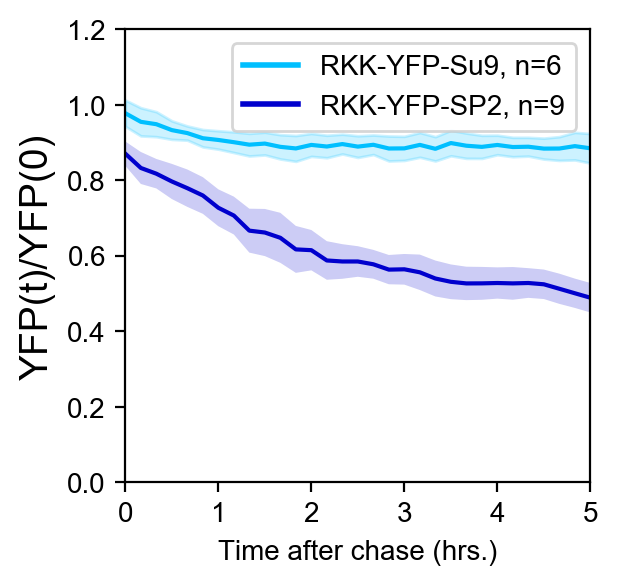

In [8]:
fig = plt.figure(figsize=(3, 3))
fig.set_dpi(200)
ax = plt.axes()

ax.set_ylim(0, 1.2)
ax.set_ylabel("YFP(t)/YFP(0)", fontsize=14)

ax.set_xlim(0, 5)
ax.set_xlabel("Time after chase (hrs.)")

x = agg_pJC034.index[0:-5]
y = agg_pJC034.yfp_norm.iloc[5:]

error = std_pJC034.yfp_norm.iloc[5:]

ax.plot(x, y,
        color='deepskyblue')
ax.fill_between(x, y-error, y+error,
                 alpha=0.2, color='deepskyblue')

x = agg_pJC033.index[0:-9]
y = agg_pJC033.yfp_norm.iloc[9:]

error = std_pJC033.yfp_norm.iloc[9:]

ax.plot(x, y,
        color='mediumblue')
ax.fill_between(x, y-error, y+error,
                 alpha=0.2, facecolor='mediumblue')

custom_lines = [Line2D([0], [0], color='deepskyblue', lw=2),
                Line2D([0], [0], color='mediumblue', lw=2)]
ax.legend(custom_lines, ['RKK-YFP-Su9, n=6', 'RKK-YFP-SP2, n=9'])



### 20191223 (old rpn4 with pJC034) individual decay traces

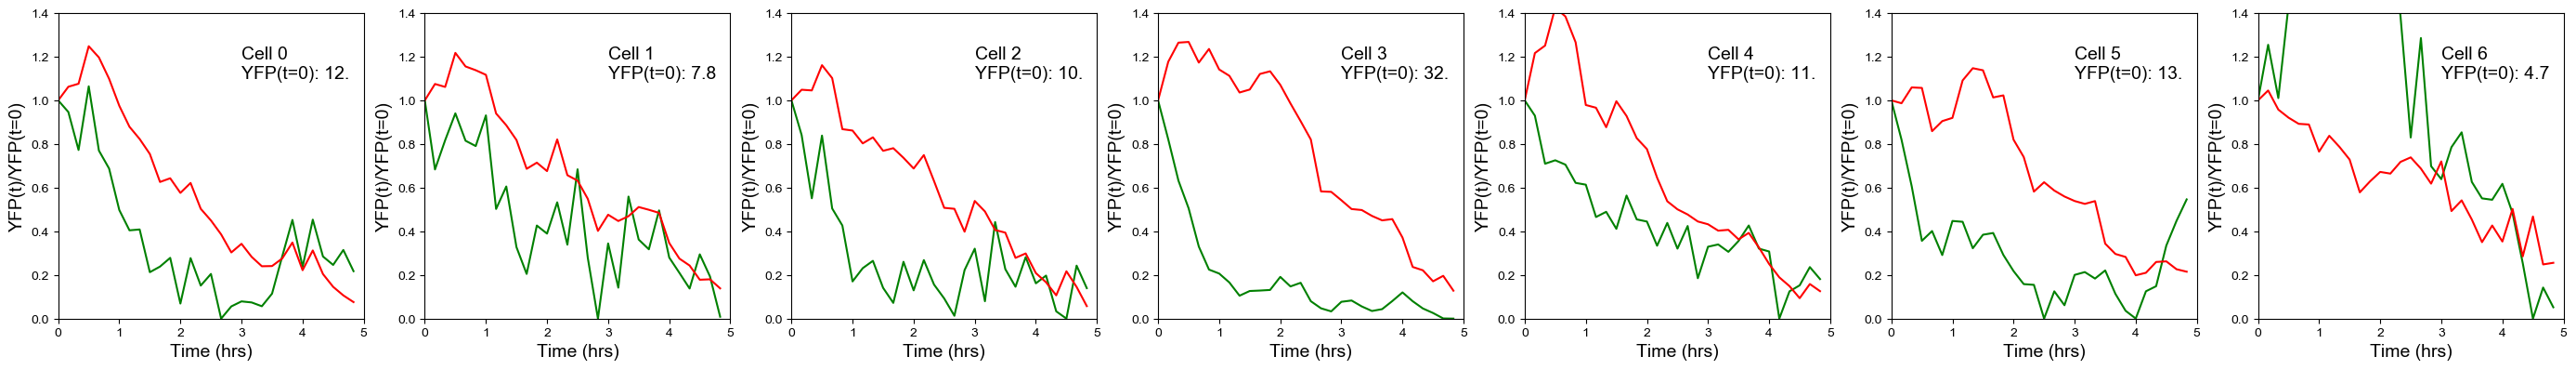

In [33]:
data = by4741_young_pJC034_data
n_cells = len(data)

start_frame = 6
end_frame = start_frame + 30

fig = plt.figure(figsize=(45,35))
fig.set_dpi(100)

for i in range(0, n_cells):
    
    df = data[i]
        
    ax = fig.add_subplot(7, 9, i+1)
    
    ax.set_xlim(0, 5)
    ax.set_xticks(np.arange(0, 6, 1))
    ax.set_xlabel("Time (hrs)", fontsize=14)
    
    ax.set_ylim(0, 1.4)
    ax.set_yticks(np.arange(0, 1.6, 0.2))
    ax.set_ylabel('YFP(t)/YFP(t=0)', fontsize=14)
    
    if end_frame <= df.index.max():
        
        x = df.hours[0:end_frame-start_frame]

        y_yfp_raw = df.yfp_mean[start_frame:end_frame] - df.yfp_mean[start_frame:end_frame].min()
        y_yfp_norm = y_yfp_raw/y_yfp_raw[start_frame]
        
        y_dsred_raw = df.dsred_mean[start_frame:end_frame] - df.dsred_mean.min()
        y_dsred_norm = y_dsred_raw/y_dsred_raw[start_frame]
        
    elif end_frame > df.index.max():
        
        new_end_frame = df.index.max()
        x = df.hours[0:new_end_frame-start_frame]

        y_yfp_raw = df.yfp_mean[start_frame:new_end_frame] - df.yfp_mean[start_frame:new_end_frame].min()
        y_yfp_norm = y_yfp_raw/y_yfp_raw[start_frame]
        
        y_dsred_raw = df.dsred_mean[start_frame:new_end_frame] - df.dsred_mean.min()
        y_dsred_norm = y_dsred_raw/y_dsred_raw[start_frame]
        
    #SP = df.dist_from_sen[df.index.min()]
    ax.annotate(f'Cell {i} \nYFP(t=0): {str(y_yfp_raw[start_frame])[0:3]}',
                xy=(3, 1.1),
                fontsize=(14))
    
    ax.plot(x, y_yfp_norm, color='green')
    ax.plot(x, y_dsred_norm, color='red')

### Define exponential decay function and method for fitting datasets as they are read in

### Fitting function

In [8]:
def fit_exp(cell_df, start_frame, end_frame):
    # define the function used for the fit, in this case an exponential
    # decay with b as the rate constant
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    function = func  
    
    # define the cell index for the sake of building data structures later
    cell_index = cell_df['cell_index'][0]
    age_at_chase = 0
    rls = 0
    div_duration = 0
    try:
        dist_from_sen = cell_df.dist_from_sen[cell_df.index[0]]
    except:
        dist_from_sen = np.NaN
        
    try:
        late_daughter_shape = cell_df.late_daughter_shape[cell_df.index[0]]
    except:
        late_daughter_shape = np.NaN
        
    # If the cell trace isn't as long as end_frame-start_frame, just fit
    # until the end of the trace
    if cell_df.index.max() < end_frame:
        adj_end_frame = cell_df.index.max() + 1
    else:
        adj_end_frame = end_frame + 1
    
    background = cell_df['yfp_norm'].min()
    y_raw = cell_df['yfp_norm'][start_frame: adj_end_frame] - background
    y_raw.index = range(adj_end_frame-start_frame) # do this so y_norm won't have an index and
    # residuals can be properly calculated from y_norm - y_output_norm
    y_norm = y_raw / y_raw[start_frame]
    
    x = cell_df['hours'][0: adj_end_frame-start_frame]
    
    # fit the t0 normalized data
    popt_norm, pcov_norm = curve_fit(function, x, y_norm)
    y_output_norm = func(x, popt_norm[0], popt_norm[1], popt_norm[2])
    #fit the raw data
    popt_raw, pcov_raw = curve_fit(function, x, y_raw)
    y_output_raw = func(x, popt_raw[0], popt_raw[1], popt_raw[2])
    
    # define a dataframe to accessibly store fit parameters and their errors
    fit_data = {'cell_index': [cell_index],
                'late_daughter_shape': late_daughter_shape,
                'rls': rls,
                'div_duration': div_duration,
                'age_at_chase': age_at_chase,
                'dist_from_sen': dist_from_sen,
                'a_norm': [popt_norm[0]], 'b_norm': [popt_norm[1]], 'c_norm': [popt_norm[2]],
                'a_norm_err': [pcov_norm[0,0]], 'b_norm_err': [pcov_norm[1,1]], 'c_norm_err': [pcov_norm[2,2]],
                'a_raw': [popt_raw[0]], 'b_raw': [popt_raw[1]], 'c_raw': [popt_raw[2]],
                'a_raw_err': [pcov_raw[0,0]], 'b_raw_err': [pcov_raw[1,1]], 'c_raw_rerr': [pcov_raw[2,2]]
               }
    
    fit_df = pd.DataFrame.from_dict(fit_data)
    
    params_dict = {'x_input': x,
                   'y_input_raw': y_raw,
                   'y_input_norm': y_norm,
                   'y_output_norm': y_output_norm,
                   'residual': y_norm-y_output_norm,
                   'popt_norm': popt_norm,
                   'pcov_norm': pcov_norm,
                   'y_output_raw': y_output_raw,
                   'popt_raw': popt_raw,
                   'pcov_raw': pcov_raw,
                   'fit_df': fit_df
                  }
    
    return params_dict

def fit_dataset_exp(dfs_list, start_frame, end_frame):
    
    fit_dicts = []
    fit_dfs = []    
  
    for cell_df in dfs_list:
        
        try:
            params = fit_exp(cell_df, start_frame, end_frame)
        
            fit_dicts.append(params)
            fit_dfs.append(params['fit_df'])
        except:
            print(f'Fitting failed for cell {cell_df.cell_index[0]}')

    master_fit_df = pd.concat(fit_dfs, ignore_index=True)
        
    return fit_dicts, master_fit_df

In [9]:
def scan_start_frames(cell_df, fit_func=fit_exp, window_size=30):
    """ 
    Fit all possible windows of size window_size using the function.
    Return a dictionary called scan_fit_dict with (start_frame, end_frame) 
    of each window as keys and the params_dict output from fit_exp() using
    curve_fit() as the value. 
    """

    fit_results = []
    fit_windows = []

    for timepoint in cell_df.Slice:

        start_frame = timepoint
        end_frame = timepoint + window_size
        # Check if end frame is out of index, if not 
        if start_frame in cell_df.Slice and end_frame in cell_df.Slice:
            #print(f'Found window at ({start_frame}, {end_frame})')
            fit_windows.append(tuple((start_frame, end_frame)))
            try:
                # should only fail if data cannot be fit with exponential
                params_dict = fit_func(cell_df, start_frame,
                                       end_frame)
                fit_results.append(params_dict)
            except:
                fit_results.append(False)

        else: # This window is out of range of the data
            pass

    scan_fit_dict = dict(zip(fit_windows, fit_results))
    
    return scan_fit_dict

def get_err_df(scanned_fit_dict):

    start_frames = [key_tuple[0] for key_tuple in scan_fit_dict.keys()]
    columns = ['start_frame', 'b_err', 'b', 'residual_med', 'residual_ss']
    b_errs = []
    b_values = []
    residual_meds = []
    residual_ss = []

    for window, params_dict in scan_fit_dict.items():

        if params_dict != False:
            pcov_norm = params_dict['pcov_norm']
            perr = np.sqrt(np.diag(pcov_norm))
            b = params_dict['popt_norm'][1]
            residual_med = params_dict['residual'].median()
            residual_ss_i = np.power(params_dict['residual'], 2).sum()
            residual_ss.append(residual_ss_i)
            
            b_errs.append(perr[1])
            b_values.append(b)
            residual_meds.append(residual_med)
        else:
            b_errs.append(np.NaN)
            b_values.append(np.NaN)
            residual_meds.append(np.NaN)
            residual_ss.append(np.NaN)
            print('No fit at', window, 'window')

    b_errs = np.array(b_errs)        
    df_dict = dict(zip(columns, [start_frames,
                                 b_errs, b_values,
                                 residual_meds,
                                 residual_ss]))
    err_df = pd.DataFrame(df_dict)
    
    return err_df

The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).

Output a dataframe with slice number and b_err. If failed fit then put NaN

In [11]:
cell_df = by4741_young_pJC034_data[0]
params_dict = fit_exp(cell_df, 5, 35)

In [12]:
params_dict.keys()
#params_dict['popt_norm']

dict_keys(['x_input', 'y_input_raw', 'y_input_norm', 'y_output_norm', 'residual', 'popt_norm', 'pcov_norm', 'y_output_raw', 'popt_raw', 'pcov_raw', 'fit_df'])

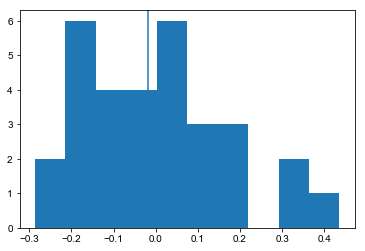

In [13]:
plt.hist(params_dict['residual'])
plt.axvline(params_dict['residual'].median())

### Reading in lists of .csvs, one for each cell

In [14]:
by4741_young_pJC033_data = sa.get_dfs_list() # from 20191213_byc

In [4]:
by4741_young_pJC034_data = sa.get_dfs_list() # from 20191223_byc

In [5]:
by4741_young_pJC031_data = sa.get_dfs_list() # from 20191106_byc (UbL...NS)

In [56]:
dfs_list = by4741_young_pJC033_data
chase_start = 9

for df in dfs_list:
    df['construct'] = 'pJC033'
    df['tail'] = 'Su9'
    df['N-end'] = 'RKK'
    df.loc[:, 'yfp_bg_sub']  = df.yfp_mean - df.yfp_mean.min()
    df.loc[:, 'dsred_bg_sub'] = df.dsred_mean - df.dsred_mean.min()
    df.loc[:, 'yfp_norm'] = df.yfp_mean / df.yfp_mean.max()
    df.loc[:, 'dsred_norm'] = df.dsred_mean / df.dsred_mean.max()

In [57]:
dfs_list = by4741_young_pJC034_data
chase_start = 5

for df in dfs_list:
    df['construct'] = 'pJC033'
    df['tail'] = 'Su9'
    df['N-end'] = 'RKK'
    df.loc[:, 'yfp_bg_sub']  = df.yfp_mean - df.yfp_mean.min()
    df.loc[:, 'dsred_bg_sub'] = df.dsred_mean - df.dsred_mean.min()
    df.loc[:, 'yfp_norm'] = df.yfp_mean / df.yfp_mean.max()
    df.loc[:, 'dsred_norm'] = df.dsred_mean / df.dsred_mean.max()

In [10]:
dfs_list = by4741_young_pJC031_data
chase_start = 5

for df in dfs_list:
    df['construct'] = 'pJC031'
    df['tail'] = 'NS'
    df['N-end'] = 'UbL'
    df.loc[:, 'yfp_bg_sub']  = df.yfp_mean - df.yfp_mean.min()
    df.loc[:, 'dsred_bg_sub'] = df.dsred_mean - df.dsred_mean.min()
    df.loc[:, 'yfp_norm'] = df.yfp_mean / df.yfp_mean.max()
    df.loc[:, 'dsred_norm'] = df.dsred_mean / df.dsred_mean.max()

### Which measure of error in fits across windows (start_frame, end_frame) is best prescriber of where final start_frame should be?

I think I should do this residuals + error analysis on median of cells in dataset (they need to be aligned on whatever I call time of media switch to tet) and use that to find best start point because these are pretty all over the place

In [12]:
df = by4741_young_pJC031_data[1]
scan_fit_dict = scan_start_frames(df, fit_func=fit_exp)
err_df = get_err_df(scan_fit_dict)
true_chase_start = 5

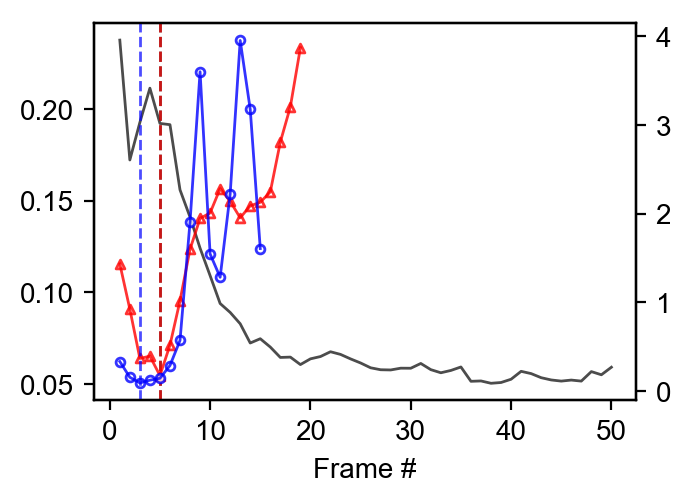

In [11]:
df = by4741_young_pJC031_data[1]
scan_fit_dict = scan_start_frames(df, fit_func=fit_exp)
err_df = get_err_df(scan_fit_dict)
true_chase_start = 5

fig = plt.figure(figsize=(3.5, 2.5))
fig.set_dpi(200)

axvlinewidth = 1
axvlinealpha = 0.7
linewidth = 1
xlabel = ('Frame #')


# Plot trace for this individual cell
ax1 = plt.axes()
ax1.plot(df.Slice, df.yfp_bg_sub,
         color='black', alpha=0.7, linewidth=linewidth)
ax1.axes.get_yaxis().set_visible(False) # hide this 
# axis so it won't overlap below
ax1.set_xlabel(xlabel)
ax1.axvline(true_chase_start, linewidth=axvlinewidth,
            color='black', linestyle='--', alpha=axvlinealpha)

# Plot b_err (the std. deviation for that fit)
# vs. start_frame for that fit
ax2 = ax1.twinx()
ax2.scatter(err_df.start_frame, err_df.b_err,
            color='white', edgecolors='red',
            marker="^", alpha=0.8, s=10)

ax2.plot(err_df.start_frame, err_df.b_err,
            color='red', alpha=0.8, linewidth=1)

ax2.axvline(err_df.start_frame[err_df.b_err.idxmin()],
            color='red', linestyle='--', alpha=axvlinealpha,
            linewidth=axvlinewidth)

# Plot median residual vs start frame for each fit
ax3 = ax2.twinx()

ax3.scatter(err_df.start_frame[0:15], err_df.residual_ss[0:15],
            color='white', edgecolors='blue',
            marker="o", alpha=0.8, s=10)

ax3.plot(err_df.start_frame[0:15], err_df.residual_ss[0:15],
            color='blue', alpha=0.8, linewidth=linewidth)

ax3.axvline(err_df.start_frame[err_df.residual_ss.idxmin()],
            color='blue', linestyle='--', alpha=axvlinealpha,
            linewidth=axvlinewidth)
#ax3.set_ylim(0, 10)

plt.show()

### Looking for the best fit point across (start_frame, end_frame) windows on median aggregates of cells

In [76]:
all_pJC031.yfp_mean[5].median()

270.653

In [82]:
all_pJC033.yfp_mean[9].median()

385.759

In [77]:
all_pJC034.yfp_mean[5].median()

193.565

In [51]:
all_pJC033 = pd.concat(by4741_young_pJC033_data)
all_pJC034 = pd.concat(by4741_young_pJC034_data)
all_pJC031 = pd.concat(by4741_young_pJC031_data)

agg_pJC033 = all_pJC033.groupby('Slice').median().reset_index()
agg_pJC034 = all_pJC034.groupby('Slice').median().reset_index()
agg_pJC031 = all_pJC031.groupby('Slice').median().reset_index()

std_pJC033 = all_pJC033.loc[:, ['yfp_norm', 'dsred_norm', 'hours']].groupby(by='hours').std()
std_pJC034 = all_pJC034.loc[:, ['yfp_norm', 'dsred_norm', 'hours']].groupby(by='hours').std()
std_pJC031 = all_pJC031.loc[:, ['yfp_norm', 'dsred_norm', 'hours']].groupby(by='hours').std()

No fit at (12, 42) window
No fit at (13, 43) window
No fit at (14, 44) window
No fit at (15, 45) window
No fit at (16, 46) window
No fit at (17, 47) window
No fit at (18, 48) window
4


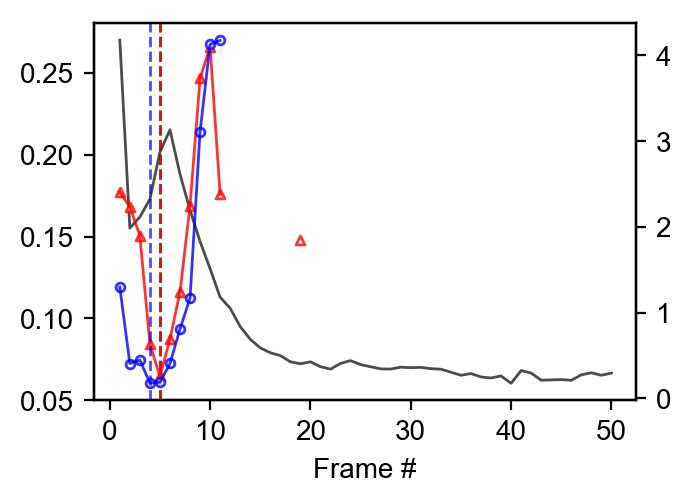

In [95]:
df = agg_pJC031
scan_fit_dict = scan_start_frames(df, fit_func=fit_exp)
err_df = get_err_df(scan_fit_dict)
true_chase_start = 5

fig = plt.figure(figsize=(3.5, 2.5))
fig.set_dpi(200)

axvlinewidth = 1
axvlinealpha = 0.7
linewidth = 1
xlabel = ('Frame #')


# Plot trace for this individual cell
ax1 = plt.axes()
ax1.plot(df.Slice, df.yfp_bg_sub,
         color='black', alpha=0.7, linewidth=linewidth)
ax1.axes.get_yaxis().set_visible(False) # hide this 
# axis so it won't overlap below
ax1.set_xlabel(xlabel)
ax1.axvline(true_chase_start, linewidth=axvlinewidth,
            color='black', linestyle='--', alpha=axvlinealpha)

# Plot b_err (the std. deviation for that fit)
# vs. start_frame for that fit
ax2 = ax1.twinx()
ax2.scatter(err_df.start_frame, err_df.b_err,
            color='white', edgecolors='red',
            marker="^", alpha=0.8, s=10)

ax2.plot(err_df.start_frame, err_df.b_err,
            color='red', alpha=0.8, linewidth=1)

ax2.axvline(err_df.start_frame[err_df.b_err.idxmin()],
            color='red', linestyle='--', alpha=axvlinealpha,
            linewidth=axvlinewidth)

# Plot median residual vs start frame for each fit
ax3 = ax2.twinx()

ax3.scatter(err_df.start_frame[0:15], err_df.residual_ss[0:15],
            color='white', edgecolors='blue',
            marker="o", alpha=0.8, s=10)

ax3.plot(err_df.start_frame[0:15], err_df.residual_ss[0:15],
            color='blue', alpha=0.8, linewidth=linewidth)

ax3.axvline(err_df.start_frame[err_df.residual_ss.idxmin()],
            color='blue', linestyle='--', alpha=axvlinealpha,
            linewidth=axvlinewidth)



print(err_df.b_err.idxmin())
plt.show()

In [26]:
err_df.residual_ss.idxmin()

6

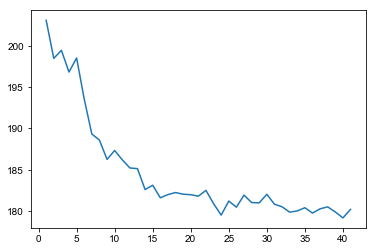

In [243]:
plt.plot(agg_pJC034.yfp_mean)

### How to structure final output_df per cell:
Columns:
* x_input
* y_input
* y_output (predicted from fit)
* residual (y_input - y_output)

In [185]:
pJC033_young_fits, pJC033_young_fits_df = fit_dataset_exp(by4741_young_pJC033_data, 9, 39)
pJC033_young_fits_df.b_norm.median()

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


0.49786937228904604

In [194]:
pJC034_young_fits, pJC034_young_fits_df = fit_dataset_exp(by4741_young_pJC034_data, 5, 35, 340, func)
pJC034_young_fits_df.b_norm.median()

1.2843468940437779

In [195]:
pJC034_young_fits_df['tail'] = 'Su9'
pJC033_young_fits_df['tail'] = 'SP2'

all_by4741_33_34_fits_df = pd.concat([pJC033_young_fits_df, pJC034_young_fits_df])

all_by4741_33_34_fits_df.to_csv("20191213_and_by4741_pJC034_pJC033_fits_df.csv")

In [6]:
all_by4741_33_34_fits_df = pd.read_csv("20191213_and_by4741_pJC034_pJC033_fits_df.csv")

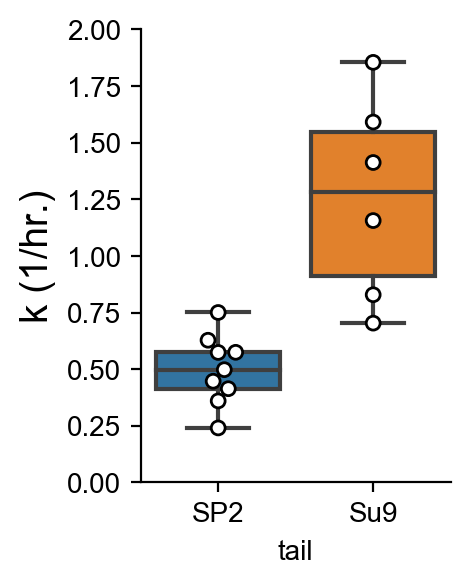

In [18]:
palette = sns.color_palette()

fig = plt.figure(figsize=(2, 3))
fig.set_dpi(200)

ax = sns.boxplot(x='tail', y='b_norm', data=all_by4741_33_34_fits_df)
ax = sns.swarmplot(x='tail', y='b_norm', data=all_by4741_33_34_fits_df,
                   edgecolor='black', linewidth=1, color='white')

ax.set_ylim(0, 2)
ax.set_ylabel("k (1/hr.)", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.savefig("rates.svg")

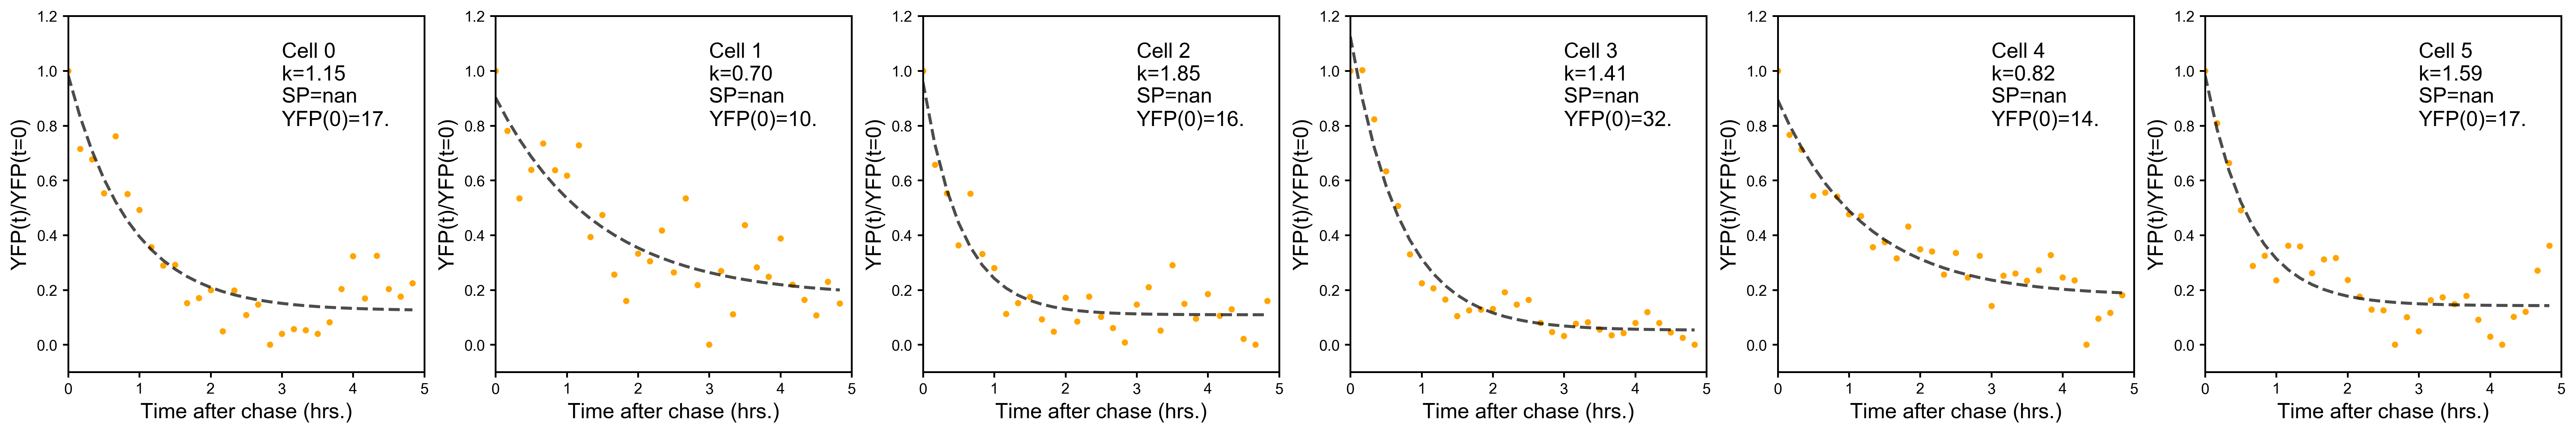

In [199]:
fit_set = pJC034_young_fits
linewidth=1.2

fig = plt.figure(figsize=(45,35))
fig.set_dpi(300)

for i in range(0, len(fit_set)):
    
    cell_index = fit_set[i]['fit_df'].cell_index[0]
    dist_from_sen = fit_set[i]['fit_df'].dist_from_sen[0]
    
    y_at_t0 = fit_set[i]['y_input_raw'][fit_set[i]['y_input_raw'].index[0]]
    
    fit_dict = fit_set[i]
    b = fit_dict['popt_norm'][1]
    b_str = str(b)[0:4]
    
    ax = fig.add_subplot(7, 9, cell_index+1)
    ax.annotate("Cell {} \nk={} \nSP={} \nYFP(0)={}".format(cell_index,
                                                    b_str,
                                                    dist_from_sen,
                                                    str(y_at_t0)[0:3]),
                                                    fontsize=14,
                                                    xy=(3, 0.8))
    
    ax.set_xlim(0, 5)
    ax.set_xticks(np.arange(0, 5.1, 1))
    ax.set_xlabel("Time after chase (hrs.)", fontsize=14)
    
    ax.set_ylim(-0.1, 1.2)
    ax.set_yticks(np.arange(0, 1.3, 0.2))
    ax.set_ylabel("YFP(t)/YFP(t=0)", fontsize=14)
    
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)
    ax.spines['bottom'].set_linewidth(linewidth)
    
    ax.xaxis.set_tick_params(width=linewidth)
    ax.yaxis.set_tick_params(width=linewidth)

    ax.plot(fit_dict['x_input'], fit_dict['y_output_norm'], color='black', alpha=0.7, linestyle='--', linewidth=2)
    ax.scatter(fit_dict['x_input'], fit_dict['y_input_norm'], alpha=1, s=10, color='orange')